In [1]:
#!pip install torch torchaudio scikit-learn numpy
#!pip install soundfile

# IMPORT

In [2]:
import os
from collections import Counter

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from src.preprocessing.dataset import (
    list_ravdess_files,
    filter_audio_speech,
    RavdessDataset,
    extract_label_idx,
    IDX2LABEL,
)
from src.models.crnn import CRNN
from src.utils import set_seed, evaluate

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report



# DEFINIZIONE DATA BASE

In [3]:

set_seed(42)

DATA_ROOT = "./data"
EPOCHS = 50
BATCH_SIZE = 64
LR = 1e-3
WEIGHT_DECAY = 1e-4

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# 1) lista file
all_files = list_ravdess_files(DATA_ROOT)
all_files = filter_audio_speech(all_files)
if len(all_files) == 0:
    raise RuntimeError("Nessun file trovato. Controlla DATA_ROOT e filter_audio_speech().")

# 2) labels per stratify
labels = [extract_label_idx(fp) for fp in all_files]
print("Tot files:", len(all_files))
print("Distribuzione classi:", Counter(labels))


Device: cuda
Tot files: 1440
Distribuzione classi: Counter({1: 192, 2: 192, 3: 192, 4: 192, 5: 192, 6: 192, 7: 192, 0: 96})


# SPLIT DATASET

In [4]:
# serve per vedere se stai usando la CPU o se hai CUDA
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device count:", torch.cuda.device_count())
print("Current device:", torch.cuda.current_device())
print("GPU name:", torch.cuda.get_device_name(0))

# IMPORTANTE
# se qui la prima riga ti ritorna True allora sotto quando scrivi i DataLoader metti i pinmemory = True

CUDA available: True
Device count: 1
Current device: 0
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


In [5]:
from src.preprocessing.dataset import parse_ravdess_filename

def split_by_speakers(filepaths, train_speakers, val_speakers, test_speakers):
    train, val, test = [], [], []
    for fp in filepaths:
        actor = parse_ravdess_filename(fp)["actor"]
        if actor in train_speakers:
            train.append(fp)
        elif actor in val_speakers:
            val.append(fp)
        elif actor in test_speakers:
            test.append(fp)
    return train, val, test

In [ ]:

# 3) split random stratificato (Phase 1: NON speaker-independent)
#train_files, temp_files, train_y, temp_y = train_test_split(
#   all_files, labels, test_size=0.30, random_state=42, stratify=labels
#)
#val_files, test_files, _, _ = train_test_split(
#    temp_files, temp_y, test_size=0.50, random_state=42, stratify=temp_y
#)

#print(f"Split -> train {len(train_files)} | val {len(val_files)} | test {len(test_files)}")

# Speaker-independent split (attori disgiunti)
train_spk = [f"{i:02d}" for i in range(1, 19)]   # 01..18
val_spk   = [f"{i:02d}" for i in range(19, 23)]  # 19..22
test_spk  = [f"{i:02d}" for i in range(23, 25)]  # 23..24

train_files, val_files, test_files = split_by_speakers(all_files, train_spk, val_spk, test_spk)

print(f"Split SI -> train {len(train_files)} | val {len(val_files)} | test {len(test_files)}")

# 4) dataset + loader
AUG_ON = True  # <-- switch globale (metti False per disattivare tutto)

aug_cfg = {
    "gain": True,
    "gain_db": (-6, 6),

    "time_shift": True,
    "time_shift_s": 0.10,

    "noise": True,
    "snr_db": (10, 30),

    "reverb": False,           # <-- prova dopo
    "reverb_ir_s": 0.12,
    "reverb_decay": 0.3,
}

train_ds = RavdessDataset(train_files, augmentation=AUG_ON, aug_config=aug_cfg)
val_ds   = RavdessDataset(val_files,   augmentation=False)   # NO augmentation su val
test_ds  = RavdessDataset(test_files,  augmentation=False)   # NO augmentation su test

# num_workers=0: più stabile su Windows/CPU (evita crash dei processi worker)
# pin_memory=False: utile solo con GPU (CUDA), su CPU non porta vantaggi
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

# 5) model
model = CRNN(n_classes=8, n_mels=128).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=6)

best_val_acc = 0.0
best_path = "best_phase1.pt"

# HISTORY PER GRAFICO 
val_acc_hist = []
test_acc_hist = []


Split SI -> train 1080 | val 240 | test 120


In [7]:

# 6) training loop
for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = torch.nn.functional.cross_entropy(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        running_correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    train_loss = running_loss / total
    train_acc = running_correct / total

    val_loss, val_acc = evaluate(model, val_loader, device)
    test_loss_epoch, test_acc_epoch = evaluate(model, test_loader, device)  # <-- test ogni epoca

    scheduler.step(val_acc)

    # salva history
    val_acc_hist.append(val_acc)
    test_acc_hist.append(test_acc_epoch)

    print(
        f"Epoch {epoch}/{EPOCHS} | "
        f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
        f"val loss {val_loss:.4f} acc {val_acc:.4f} | "
        f"test acc {test_acc_epoch:.4f}"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_path)

Epoch 1/50 | train loss 2.0413 acc 0.1759 | val loss 2.0686 acc 0.1458 | test acc 0.1417
Epoch 2/50 | train loss 1.9226 acc 0.2583 | val loss 2.1299 acc 0.1417 | test acc 0.1417
Epoch 3/50 | train loss 1.8130 acc 0.3213 | val loss 1.8144 acc 0.3250 | test acc 0.2667
Epoch 4/50 | train loss 1.6491 acc 0.3963 | val loss 1.6627 acc 0.3958 | test acc 0.3833
Epoch 5/50 | train loss 1.5154 acc 0.4454 | val loss 1.5716 acc 0.4458 | test acc 0.3833
Epoch 6/50 | train loss 1.3768 acc 0.5009 | val loss 1.6814 acc 0.4292 | test acc 0.3333
Epoch 7/50 | train loss 1.3344 acc 0.5019 | val loss 1.4820 acc 0.4750 | test acc 0.4583
Epoch 8/50 | train loss 1.2115 acc 0.5685 | val loss 1.4270 acc 0.4625 | test acc 0.4417
Epoch 9/50 | train loss 1.1753 acc 0.5713 | val loss 1.4797 acc 0.4750 | test acc 0.4000
Epoch 10/50 | train loss 1.0855 acc 0.6213 | val loss 1.5812 acc 0.4083 | test acc 0.4417
Epoch 11/50 | train loss 0.9973 acc 0.6315 | val loss 1.4600 acc 0.5125 | test acc 0.4667
Epoch 12/50 | train

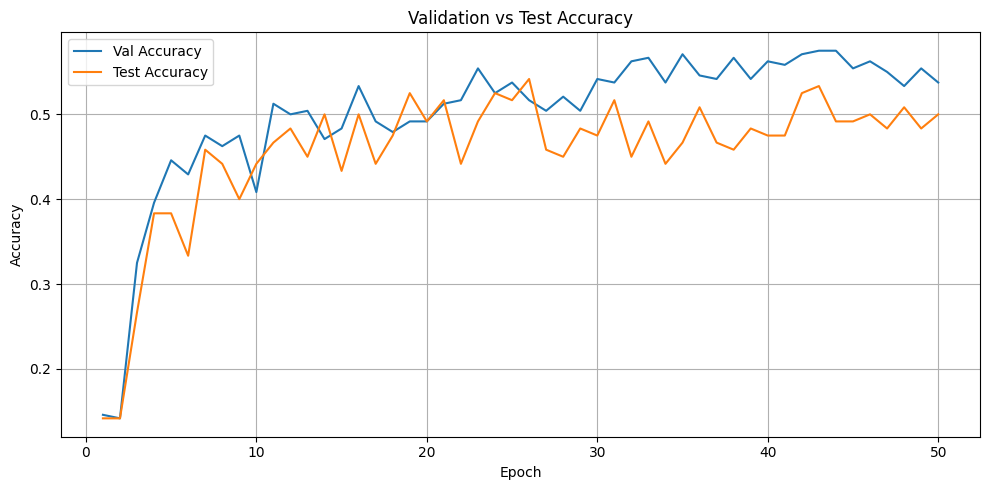


Best val acc: 0.575


C:\Users\franc\AppData\Local\Temp\ipykernel_5416\2561211432.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=dev

TEST (best checkpoint) | loss 1.8445 acc 0.5333

Classification report:
              precision    recall  f1-score   support

     neutral     0.2500    0.1250    0.1667         8
        calm     0.5714    0.7500    0.6486        16
       happy     0.3636    0.2500    0.2963        16
         sad     0.3158    0.3750    0.3429        16
       angry     0.8750    0.4375    0.5833        16
     fearful     0.6250    0.3125    0.4167        16
     disgust     0.7143    0.9375    0.8108        16
   surprised     0.5000    0.8750    0.6364        16

    accuracy                         0.5333       120
   macro avg     0.5269    0.5078    0.4877       120
weighted avg     0.5454    0.5333    0.5091       120

Confusion matrix:
[[ 1  0  2  5  0  0  0  0]
 [ 1 12  1  2  0  0  0  0]
 [ 0  0  4  3  0  1  0  8]
 [ 0  8  0  6  0  0  2  0]
 [ 0  0  0  0  7  0  4  5]
 [ 2  1  4  2  1  5  0  1]
 [ 0  0  0  1  0  0 15  0]
 [ 0  0  0  0  0  2  0 14]]


In [8]:

# Grafico accuracy train vs val
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, val_acc_hist, label="Val Accuracy")
plt.plot(epochs_range, test_acc_hist, label="Test Accuracy")
plt.title("Validation vs Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 7) test finale con best checkpoint
print("\nBest val acc:", best_val_acc)
model.load_state_dict(torch.load(best_path, map_location=device))

test_loss, test_acc = evaluate(model, test_loader, device)
print(f"TEST (best checkpoint) | loss {test_loss:.4f} acc {test_acc:.4f}")

# 8) report dettagliato
y_true = []
y_pred = []
model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = model(x).cpu()
        preds = logits.argmax(dim=1).numpy().tolist()
        y_pred.extend(preds)
        y_true.extend(y.numpy().tolist())

print("\nClassification report:")
target_names = [IDX2LABEL[i] for i in range(8)]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

print("Confusion matrix:")
print(confusion_matrix(y_true, y_pred))
